# getCFI_Ridge

This script generates cumulative feature importance (CFI) plot in the same way that getSHAP does, but feature importance is generated in terms of ridge regression coefficients instead of SHAP values. This file is meant for real traits, see getCFI_ridge_sim.ipynb for CFI of simulated traits with ridge regression coefficients.

In [1]:
import numpy as np
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

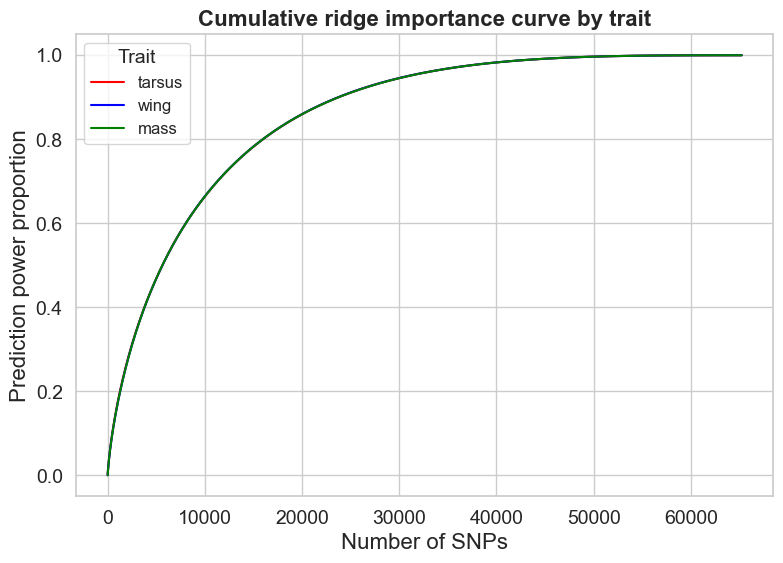

In [2]:
# Define traits and corresponding file paths
traits = ["tarsus", "wing", "mass"]
colors = ["red", "blue", "green"]  # Different colors for each trait

# Initialize a list to collect data for all traits
all_data = []

# Loop through each trait and compute cumulative deviation
for trait in traits:

    coef_values = pd.read_csv(f'C:/Users/gard_/Documents/MasterThesis/Code/Results/70k/Ridge/ridge_coefs_{trait}.csv')
    data = pd.read_feather(f'c:/Users/gard_/Documents/MasterThesis/Code/Data/Processed/{trait}BV_70k.feather')

    X = data.drop([
            "ID",
            "mean_pheno",
            "IID",
            "MAT",
            "PAT",
            "SEX",
            "PHENOTYPE",
            "hatchisland",
            "ringnr"
        ], axis = 1)

    X = X.fillna(0)


    # Filter and align both to have same SNPs in same order
    common_snps = coef_values['SNP'].isin(X.columns)
    coef_values = coef_values[common_snps].copy()
    X = X[coef_values['SNP'].values]  # re-order X to match coef_values

    # Check alignment
    assert all(coef_values['SNP'].values == X.columns.values), "SNPs not aligned!"

    # Create the variance term that is to be accumulated
    var_term = (coef_values['beta_R'].values ** 2) * X.var(axis=0).values

    # Scale and order
    var_term = -np.sort(-var_term)/(sum(var_term))

    

    cummulative_var = np.zeros(len(var_term))
    temp = 0
    for i in range(len(var_term)):
        temp += var_term[i]
        cummulative_var[i] = temp

    n_subset = len(var_term)
    x_vals = np.linspace(0, n_subset, n_subset)
    # Store results in dataframe
    df = pd.DataFrame({
        "Number of SNPs": x_vals,
        "Proportion of prediction power": cummulative_var,
        "Trait": trait
    })
    all_data.append(df)

# Combine all trait data
combined_data = pd.concat(all_data, ignore_index=True)

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Plot
plt.figure(figsize=(9, 6))
sns.lineplot(data=combined_data, x="Number of SNPs", y="Proportion of prediction power", hue="Trait", palette=colors)
plt.title("Cumulative ridge importance curve by trait", fontsize=16, weight="bold")
plt.xlabel("Number of SNPs", fontsize=16)
plt.ylabel("Prediction power proportion", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.legend(title="Trait", title_fontsize=14, fontsize=12)

# Save and show
plt.savefig("C:/Users/gard_/Documents/MasterThesis/Code/Figures/CFI_ridge_real.pdf", dpi=300, bbox_inches="tight")
plt.show()